In [1]:
!pip install -U transformers datasets evaluate accelerate scikit-learn emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Thi

In [2]:
#!pip install -q transformers datasets evaluate accelerate scikit-learn emoji

import re
import emoji
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
import evaluate

In [3]:
# ========================================
# 2. Load the unsplit dataset
# ========================================
dataset = load_dataset("dair-ai/emotion", split="train")  # 'train' here means full unsplit data
print(dataset)
print(dataset[0])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})
{'text': 'i didnt feel humiliated', 'label': 0}


Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


<Axes: title={'center': 'Label Distribution'}>

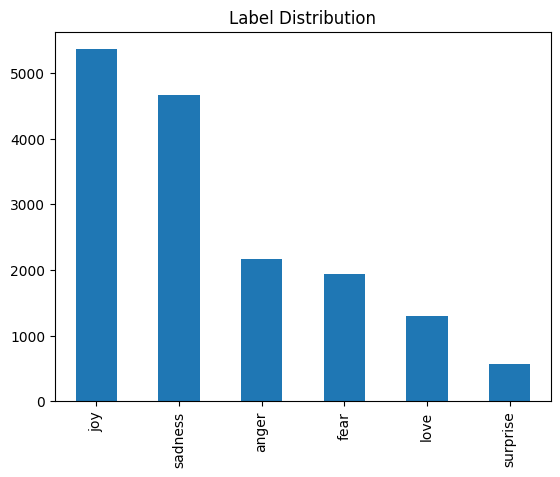

In [4]:
# ========================================
# 3. Explore the data
# ========================================
labels = dataset.features["label"].names
print("Emotion labels:", labels)

label_counts = pd.Series([labels[l] for l in dataset["label"]]).value_counts()
print(label_counts)
label_counts.plot(kind="bar", title="Label Distribution")

In [5]:
# ========================================
# 4. Preprocessing (keep emojis, clean URLs, mentions)
# ========================================
URL_RE = re.compile(r"http\S+")
MENTION_RE = re.compile(r"@\w+")
REPEAT_RE = re.compile(r"(.)\1{2,}")

def clean_text(s):
    s = URL_RE.sub("<URL>", s)
    s = MENTION_RE.sub("<USER>", s)
    s = emoji.demojize(s)
    s = REPEAT_RE.sub(r"\1\1", s)  # cap repeats
    s = s.strip()
    return s

In [6]:
# Apply cleaning
dataset = dataset.map(lambda x: {"text": clean_text(x["text"])})

# ========================================
# 5. Create custom splits (80/10/10)
# ========================================
train_df, temp_df = train_test_split(dataset.to_pandas(), test_size=0.2, stratify=dataset["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Train: 12800, Val: 1600, Test: 1600


In [7]:
# ========================================
# 6. Tokenization
# ========================================
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_enc = train_ds.map(tokenize_function, batched=True)
val_enc = val_ds.map(tokenize_function, batched=True)
test_enc = test_ds.map(tokenize_function, batched=True)

num_labels = len(labels)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [8]:
# ========================================
# 7. Model & class weights
# ========================================
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Compute class weights (to handle imbalance)
class_weights = compute_class_weight(
    "balanced",
    classes=np.arange(num_labels),
    y=train_enc["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Custom loss inside Trainer
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# ========================================
# 8. Training
# ========================================
metric_f1 = evaluate.load("f1")
metric_acc = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }
training_args = TrainingArguments(
    output_dir="./runs/emotion-distilbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=1
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics, # Keep this
    #compute_loss=compute_loss, # Remove this, custom loss is handled differently
)

# Re-define Trainer with custom loss computation
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, # Keep this
)

trainer.train()

/tmp/ipython-input-4137280489.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/tmp/ipython-input-4137280489.py:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thumula-bhashana (thumula-bhashana-sliit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.850400,0.239462,0.917500,0.891369
2,0.192500,0.259868,0.925625,0.892185


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.850400,0.239462,0.917500,0.891369
2,0.192500,0.259868,0.925625,0.892185
3,0.152400,0.197850,0.928125,0.901759


TrainOutput(global_step=2400, training_loss=0.3215103340148926, metrics={'train_runtime': 490.4741, 'train_samples_per_second': 78.292, 'train_steps_per_second': 4.893, 'total_flos': 1271777742028800.0, 'train_loss': 0.3215103340148926, 'epoch': 3.0})

              precision    recall  f1-score   support

     sadness      0.982     0.961     0.972       466
         joy      0.992     0.922     0.956       536
        love      0.779     0.977     0.867       130
       anger      0.928     0.949     0.938       216
        fear      0.907     0.907     0.907       194
    surprise      0.779     0.914     0.841        58

    accuracy                          0.939      1600
   macro avg      0.895     0.938     0.913      1600
weighted avg      0.945     0.939     0.941      1600



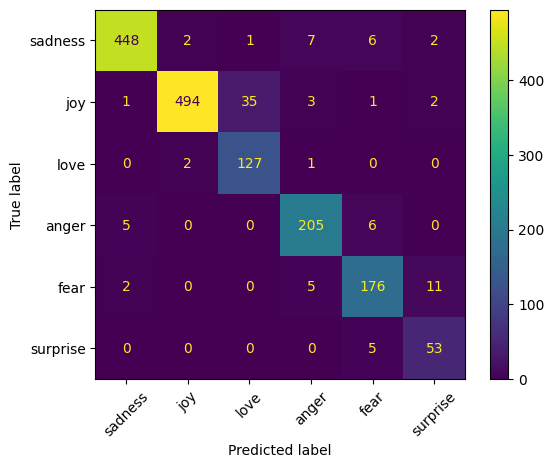

In [10]:
# ========================================
# 9. Evaluation
# ========================================
preds = trainer.predict(test_enc)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

print(classification_report(y_true, y_pred, target_names=labels, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=labels).plot(xticks_rotation=45)
plt.show()

In [14]:
# ========================================
# 10. Inference Demo
# ========================================
def predict_emotion(text):
    inputs = tokenizer(clean_text(text), return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=-1).item()
    return labels[pred]

examples = [
    "I’m so happy and excited today!",
    "This is the worst day ever.",
    "I feel nervous about tomorrow.",
    "You make me so angry sometimes.",
    "It's so annoying"
]

for t in examples:
    print(f"{t} -> {predict_emotion(t)}")

I’m so happy and excited today! -> joy
This is the worst day ever. -> sadness
I feel nervous about tomorrow. -> fear
You make me so angry sometimes. -> anger
It's so annoying -> anger
